In [4]:
import pandas as pd
import math
import numpy as np
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from multiprocessing import shared_memory
from multiprocessing.dummy import Pool
from sklearn.ensemble import RandomForestRegressor
import multiprocessing as mp
from itertools import chain, combinations
from sklearn.metrics import mean_squared_error
import sys
import os
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor

from collections import Counter


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
out_df = pd.read_csv('./output/wrky_presentation_pos_rf.csv', index_col=0)

In [3]:
out_df['bottom_mse_diff'] = out_df['bottom_mse']

In [4]:
count = 0
good_count = 0
for i, row in out_df.iterrows():
    if (row['bottom_mse'] > 0):
        count += 1
        if (row['bottom_mse'] > row['mse']):
            good_count += 1
        out_df.loc[i, 'bottom_mse_diff'] = row['mse'] - row['bottom_mse']
    else:
        out_df.loc[i, 'bottom_mse'] = np.nan
        out_df.loc[i, 'bottom_mse_diff'] = np.nan

In [5]:
good_count/count

0.8032345013477089

In [28]:
out_df.to_csv('./output/wrky_presentation_pos_rf.csv')

In [6]:
out_df = out_df.sort_values('mse')

In [21]:
count = 0.0
precision_list = []
for i, score in enumerate(out_df['top_6_score'].values):
    if (score > 0):
        count += 1
    precision_list.append(count/(i+1))


Text(0, 0.5, 'Precision')

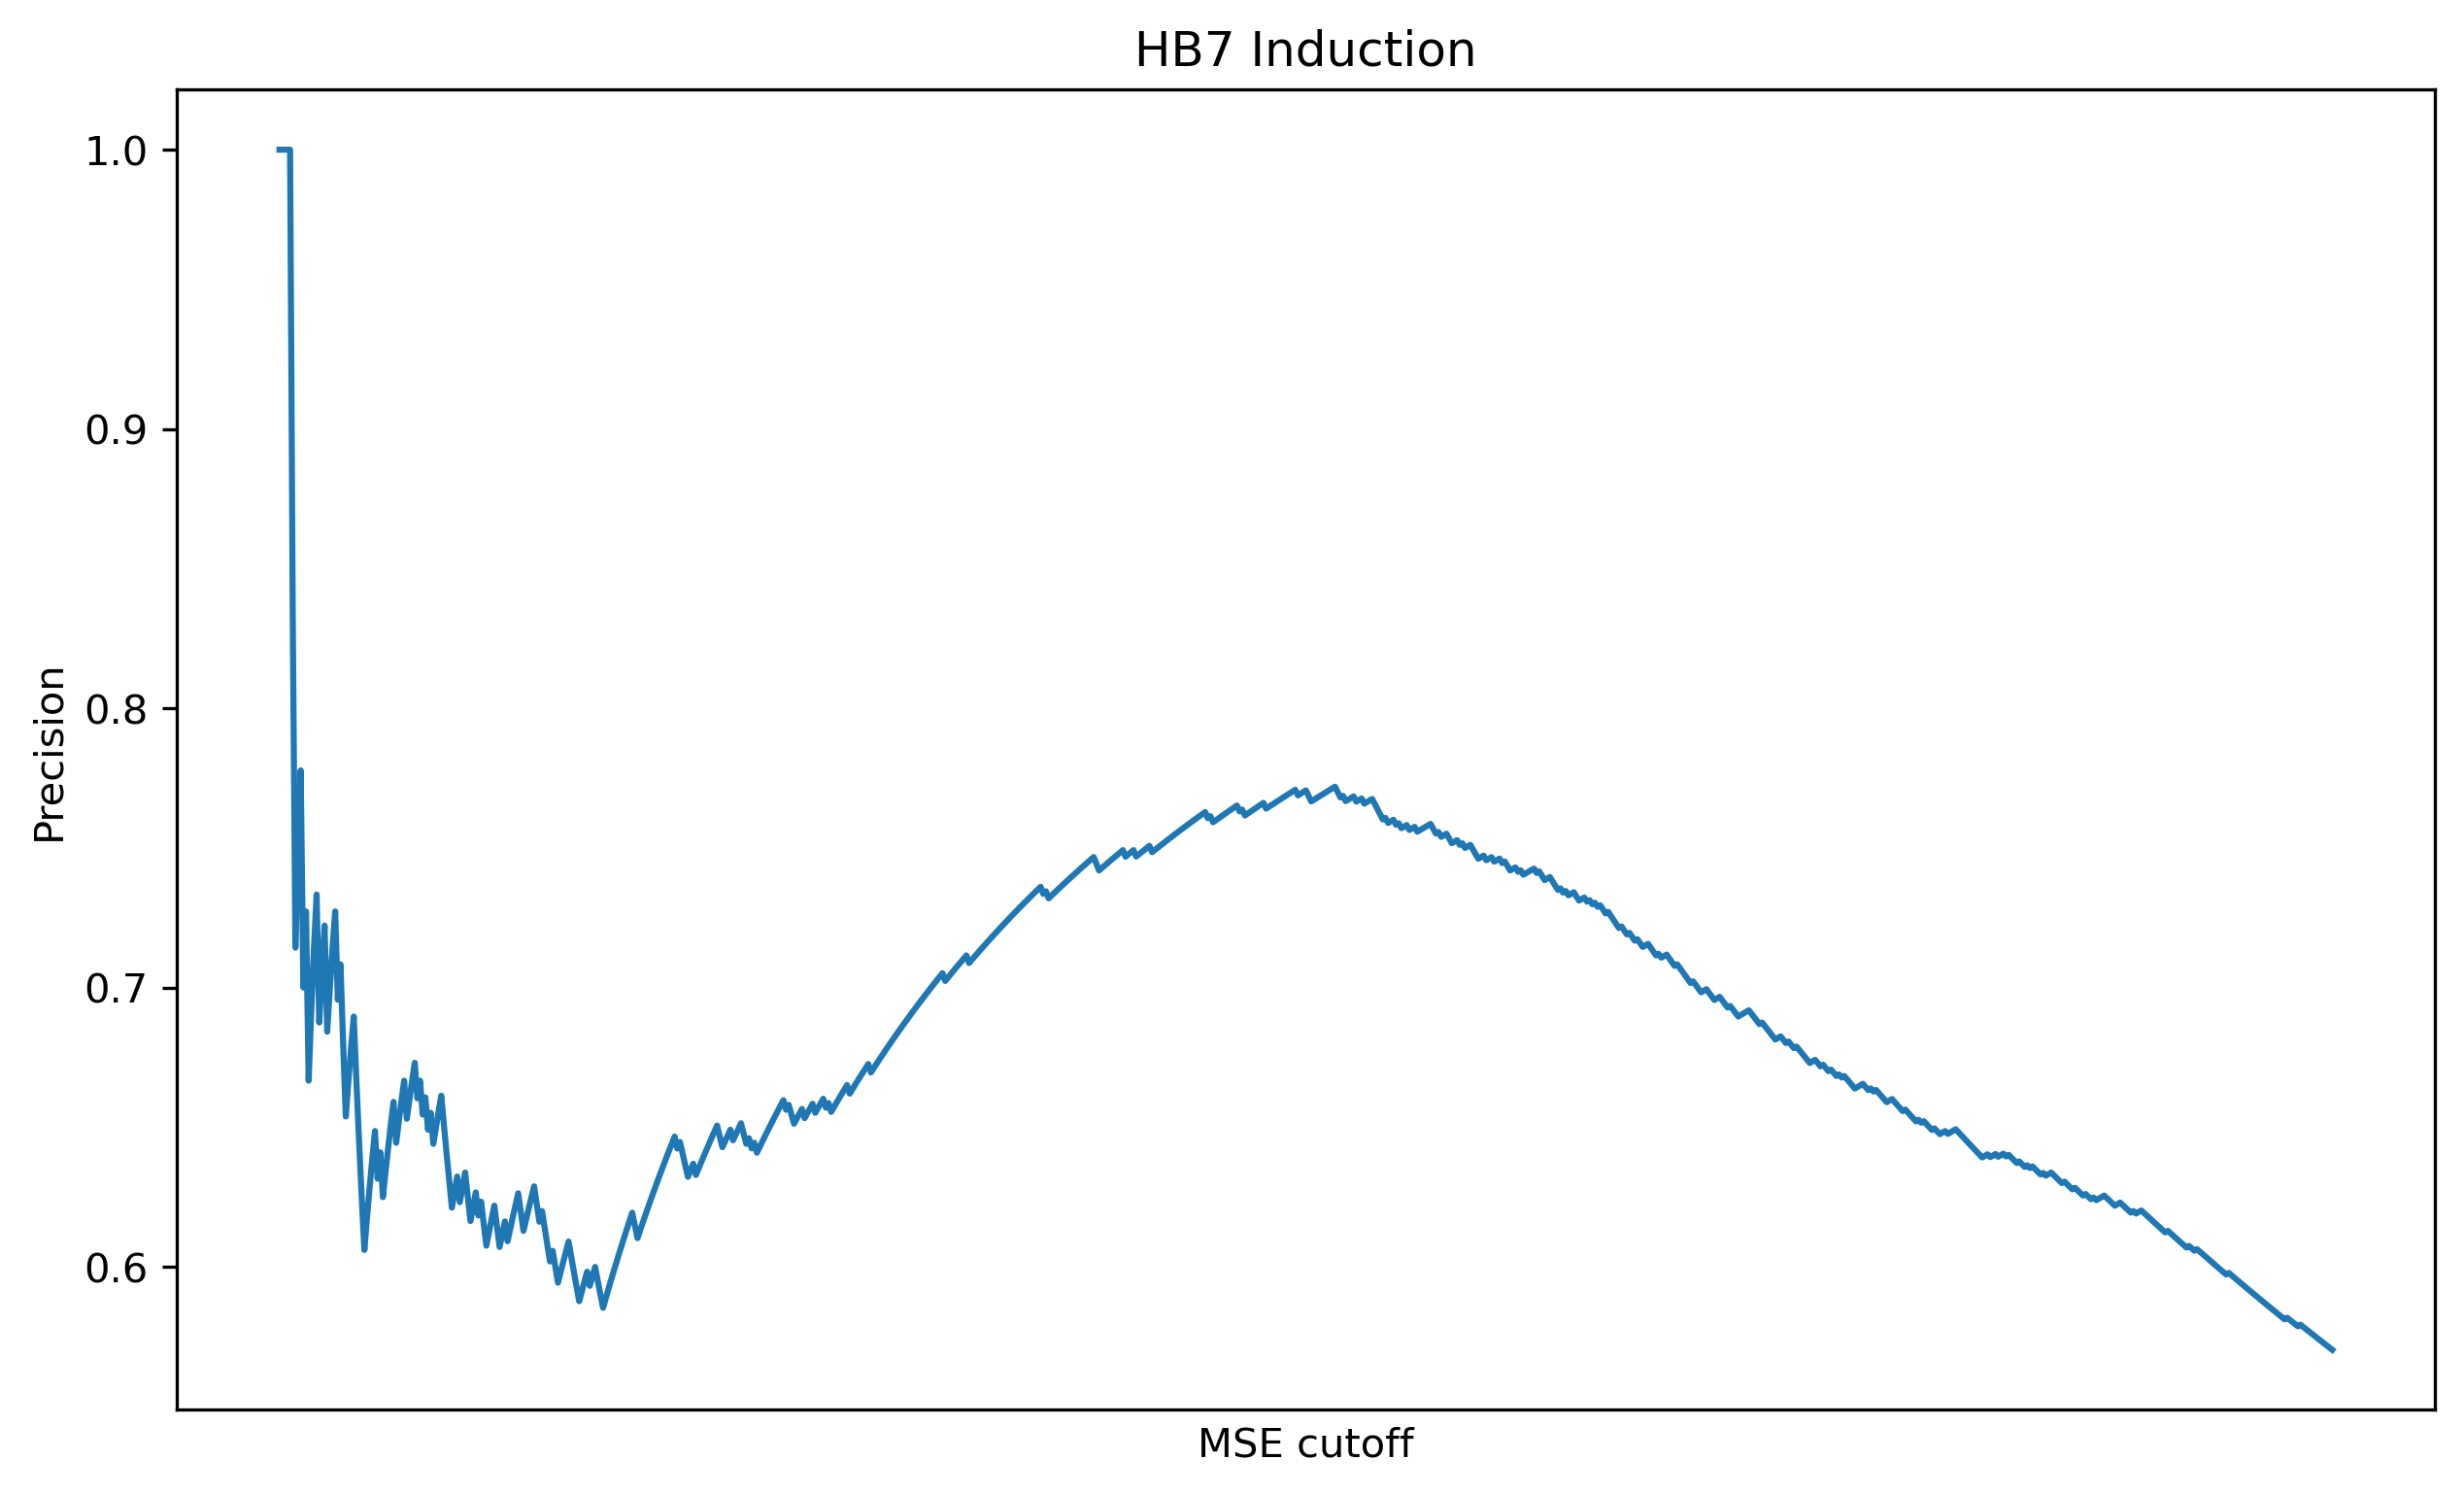

In [22]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,6)
fig.set_dpi(300)
ax1.plot(range(len(precision_list)), precision_list)
# ax1.set_yscale('log')
ax1.set_title('HB7 Induction')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.set_xlabel('MSE cutoff')
ax1.set_ylabel('Precision')

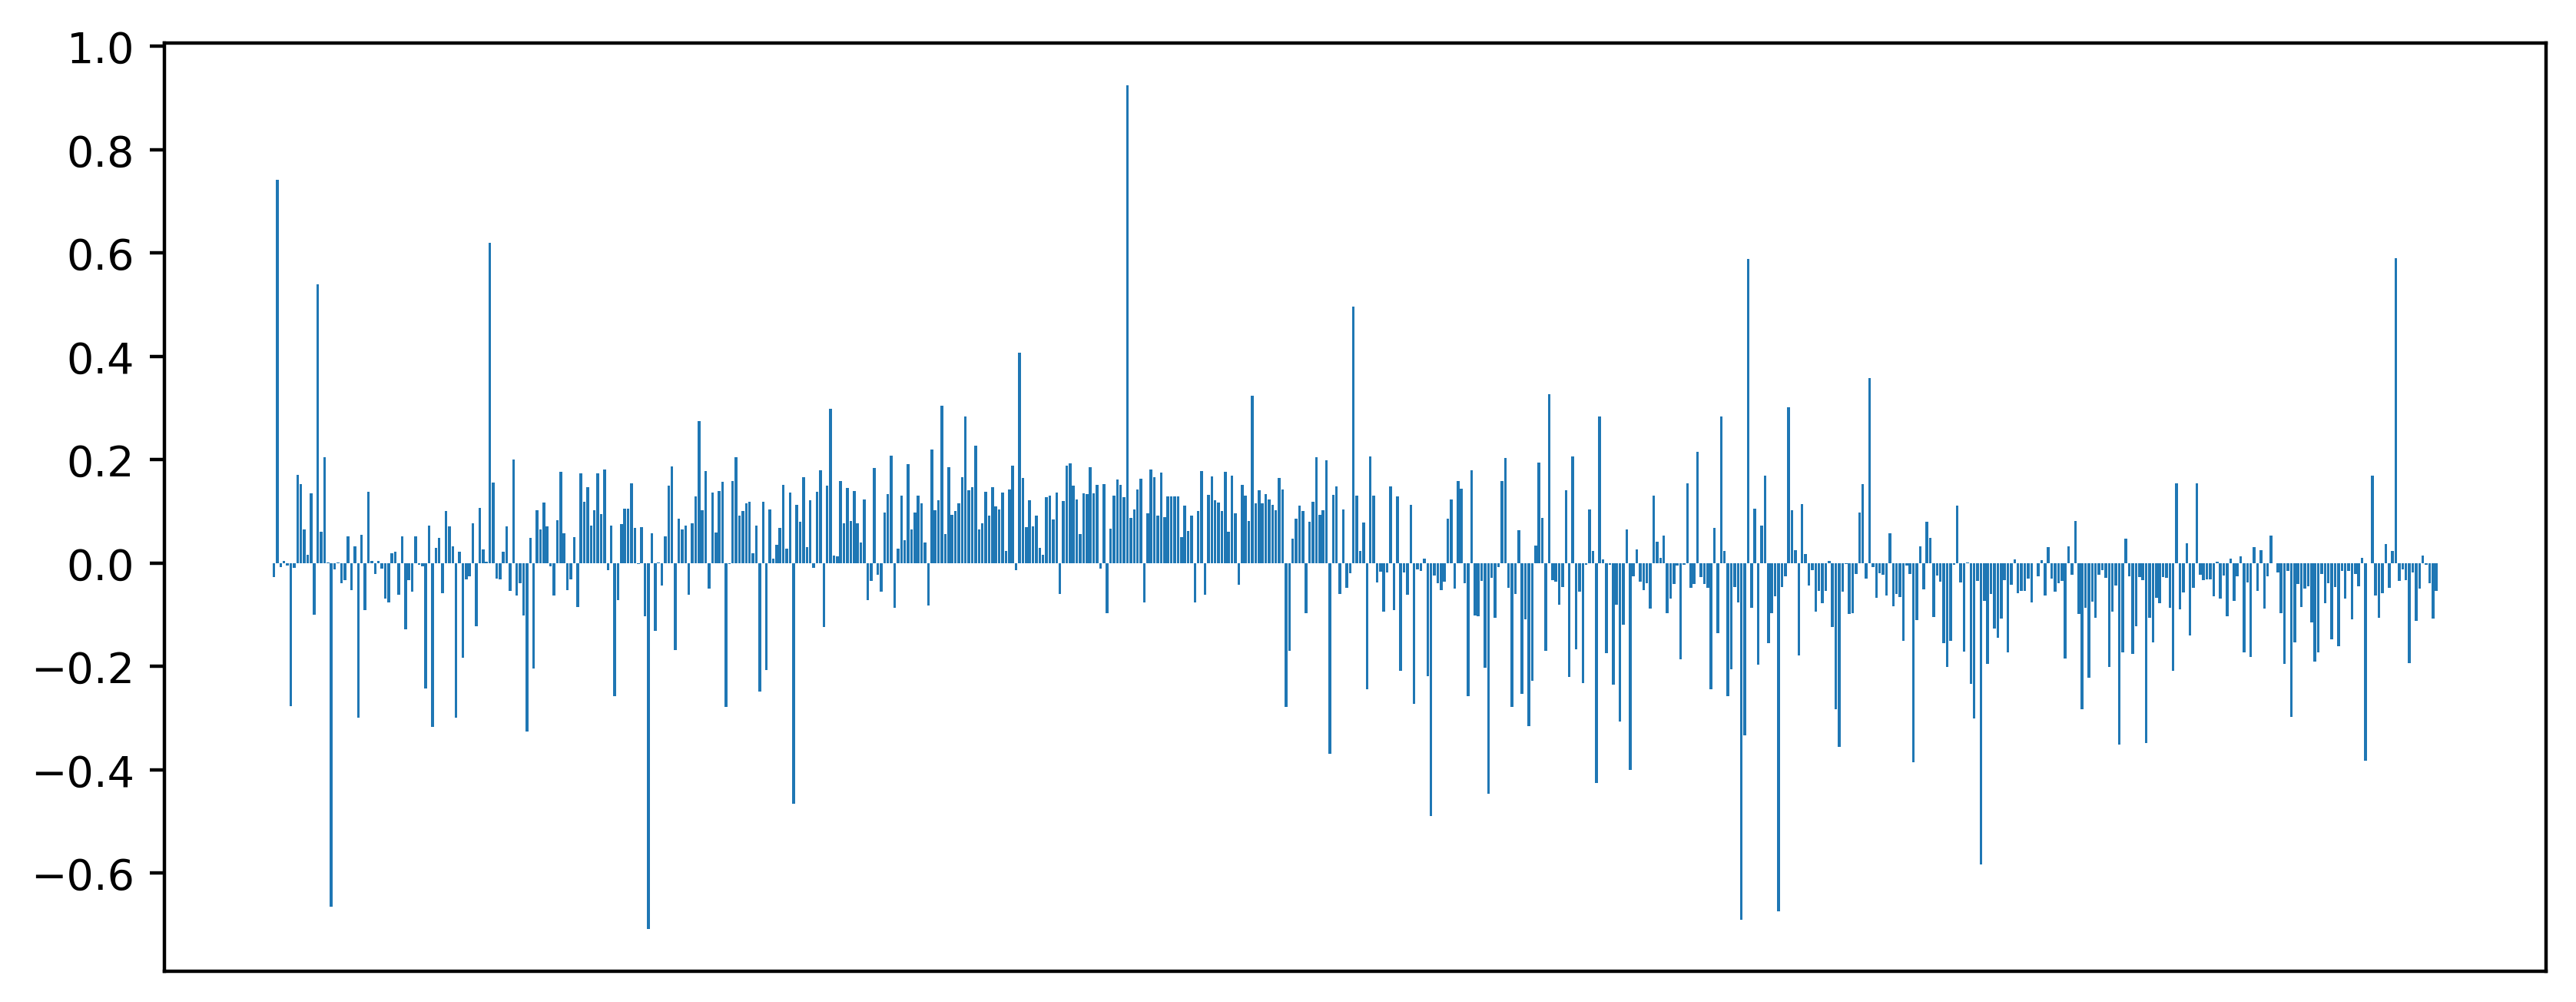

In [33]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,4)
fig.set_dpi(400)
ax1.bar(range(len(out_df)), out_df['top_6_score'])
# ax1.set_yscale('log')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax1.set_xlabel('HB7 Repressive TARGET Genes (345) With Matching Regression Effects')
# ax1.set_ylabel('Best TF Group (w/ HB7) Repression Level / \n HB7 Alone ')

In [38]:
(out_df_pos[:386]['top_6_score'] < 0).sum()

125

In [40]:
125/386

0.3238341968911917

In [2]:
def align_zeros(axes):

    ylims_current = {}   #  Current ylims
    ylims_mod     = {}   #  Modified ylims
    deltas        = {}   #  ymax - ymin for ylims_current
    ratios        = {}   #  ratio of the zero point within deltas

    for ax in axes:
        ylims_current[ax] = list(ax.get_ylim())
                        # Need to convert a tuple to a list to manipulate elements.
        deltas[ax]        = ylims_current[ax][1] - ylims_current[ax][0]
        ratios[ax]        = -ylims_current[ax][0]/deltas[ax]
    
    for ax in axes:      # Loop through all axes to ensure each ax fits in others.
        ylims_mod[ax]     = [np.nan,np.nan]   # Construct a blank list
        ylims_mod[ax][1]  = max(deltas[ax] * (1-np.array(list(ratios.values()))))
                        # Choose the max value among (delta for ax)*(1-ratios),
                        # and apply it to ymax for ax
        ylims_mod[ax][0]  = min(-deltas[ax] * np.array(list(ratios.values())))
                        # Do the same for ymin
        ax.set_ylim(tuple(ylims_mod[ax]))

In [7]:
target_df_neg = pd.read_csv('data/wrky_targets_neg.csv', index_col=0)
target_df_pos = pd.read_csv('data/wrky_targets_pos.csv', index_col=0)

In [6]:
result_df_neg = pd.read_csv('./output/wrky_presentation_neg_rf.csv', index_col=0)
result_df_pos = pd.read_csv('./output/wrky_presentation_pos_rf.csv', index_col=0)

In [8]:
target_df_neg = target_df_neg.loc[result_df_neg.index]
target_df_pos = target_df_pos.loc[result_df_pos.index]

In [9]:
target_df_neg['hb7_impact'] = result_df_neg.loc[result_df_neg.index]['top_6_score']
target_df_pos['hb7_impact'] = result_df_pos.loc[result_df_pos.index]['top_6_score']

In [10]:
target_df_pos = target_df_pos.sort_values(by='Log2FC', ascending=False)
target_df_neg = target_df_neg.sort_values(by='Log2FC')


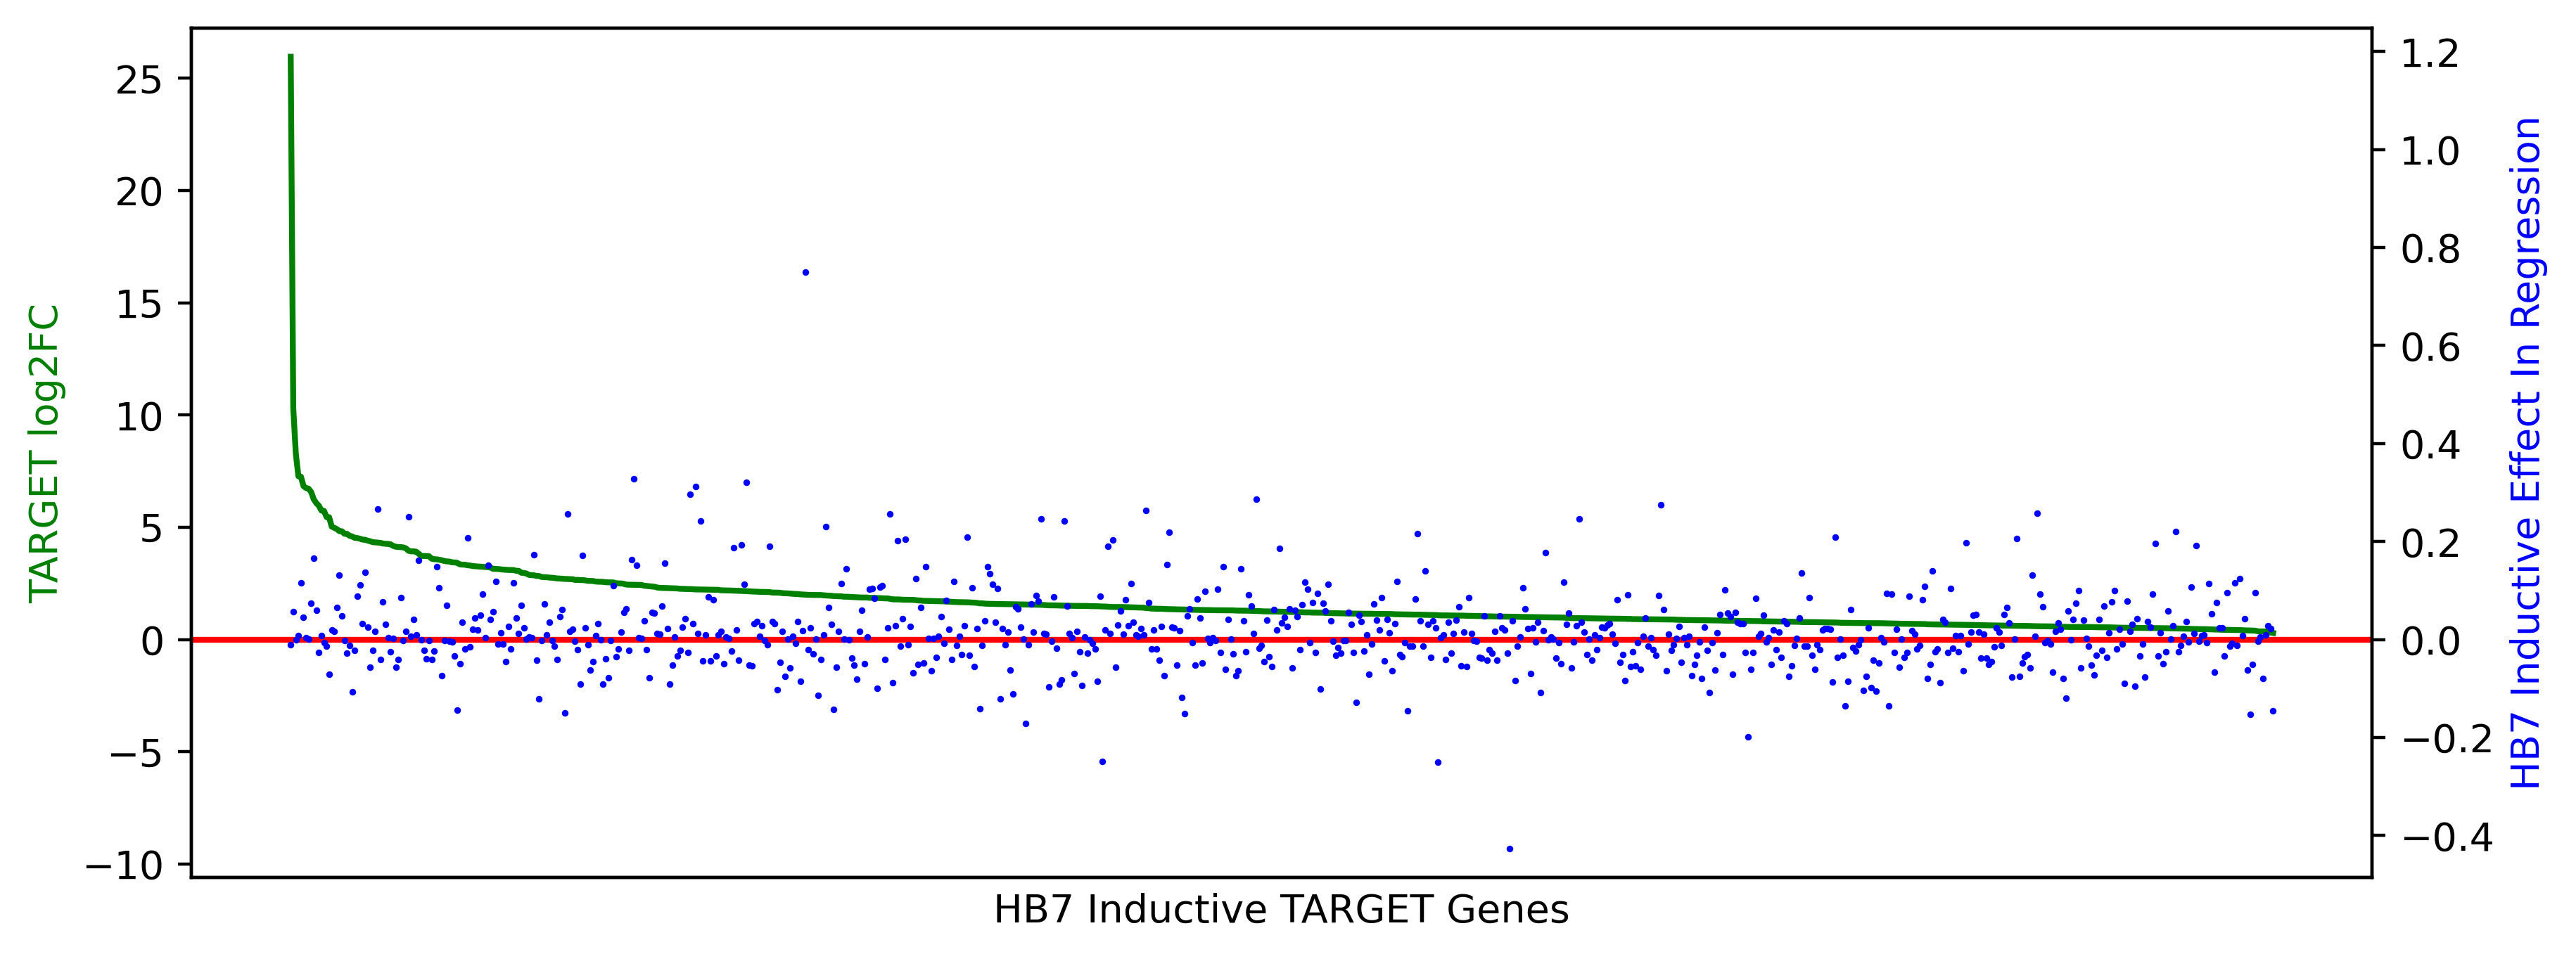

In [248]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,4)
fig.set_dpi(400)
ax2 = ax1.twinx()
ax1.plot(range(len(target_df_pos)), target_df_pos['Log2FC'], 'g-')
ax2.scatter(range(len(target_df_pos)), target_df_pos['hb7_impact'], 0.5, color='b')

ax1.set_xlabel('HB7 Inductive TARGET Genes')
ax1.set_ylabel('TARGET log2FC', color='g')
ax2.set_ylabel('HB7 Inductive Effect In Regression', color='b')
align_zeros([ax1, ax2])
ax1.axhline(0, color='r')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

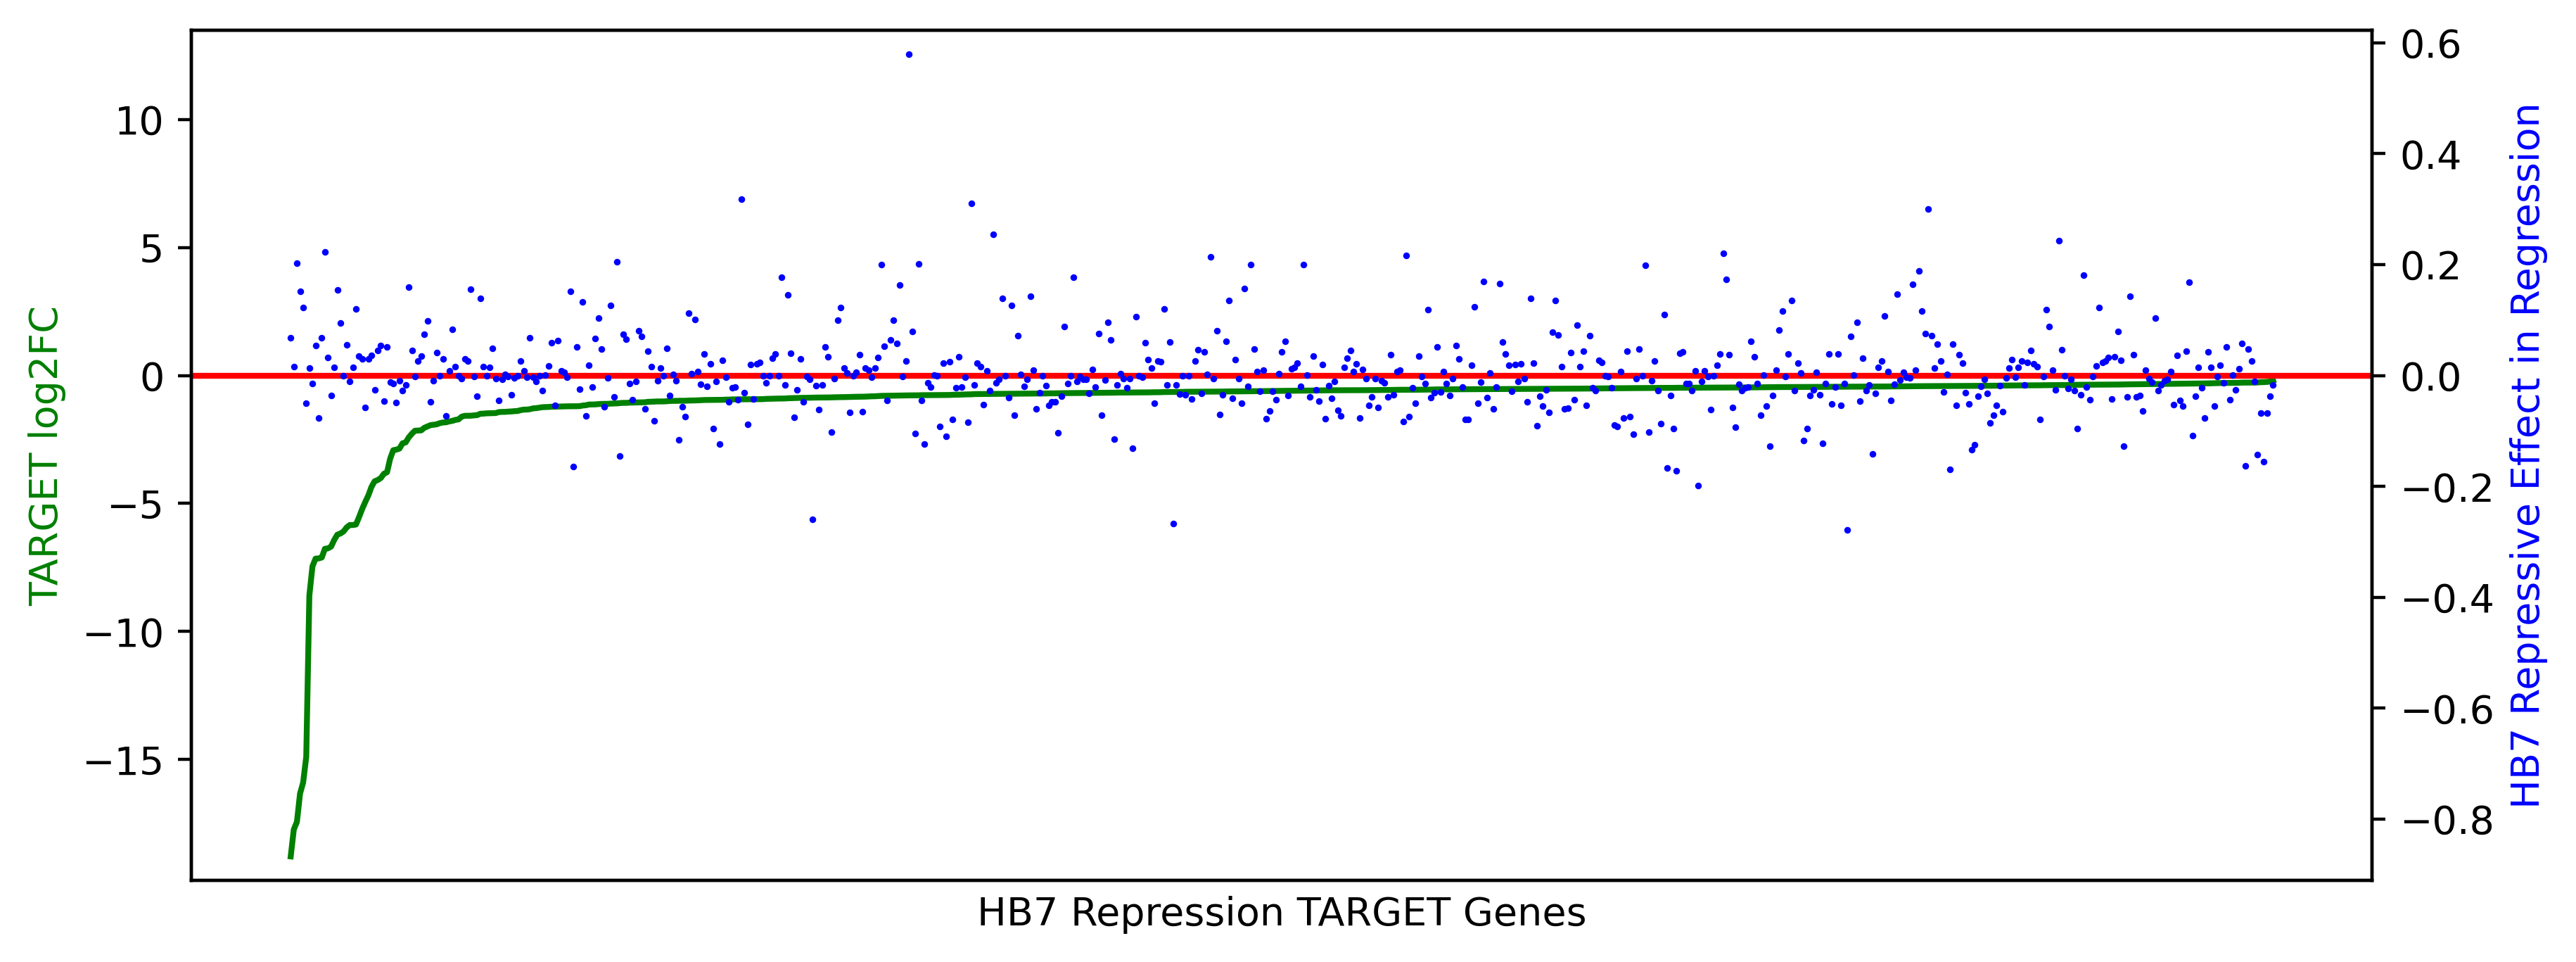

In [249]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,4)
fig.set_dpi(400)
ax2 = ax1.twinx()
ax1.plot(range(len(target_df_neg)), target_df_neg['Log2FC'], 'g-')
ax2.scatter(range(len(target_df_neg)), target_df_neg['hb7_impact'], 0.5, color='b')

ax1.set_xlabel('HB7 Repression TARGET Genes')
ax1.set_ylabel('TARGET log2FC', color='g')
ax2.set_ylabel('HB7 Repressive Effect in Regression', color='b')
align_zeros([ax1, ax2])
ax1.axhline(0, color='r')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [11]:
good_neg_df = result_df_neg.loc[result_df_neg['top_6_score'] < 0]
good_pos_df = result_df_pos.loc[result_df_pos['top_6_score'] > 0]
good_neg_df['fold_change'] = (good_neg_df['top_1_score']/good_neg_df['top_6_score']).values - 1
good_pos_df['fold_change'] = (good_pos_df['top_1_score']/good_pos_df['top_6_score']).values - 1
good_neg_df = good_neg_df.sort_values(by='fold_change', ascending=False)
good_pos_df = good_pos_df.sort_values(by='fold_change', ascending=False)

<ipython-input-11-487e726c43e5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_neg_df['fold_change'] = (good_neg_df['top_1_score']/good_neg_df['top_6_score']).values - 1
<ipython-input-11-487e726c43e5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_pos_df['fold_change'] = (good_pos_df['top_1_score']/good_pos_df['top_6_score']).values - 1


In [ ]:
good_neg_df = result_df_neg
good_pos_df = result_df_pos

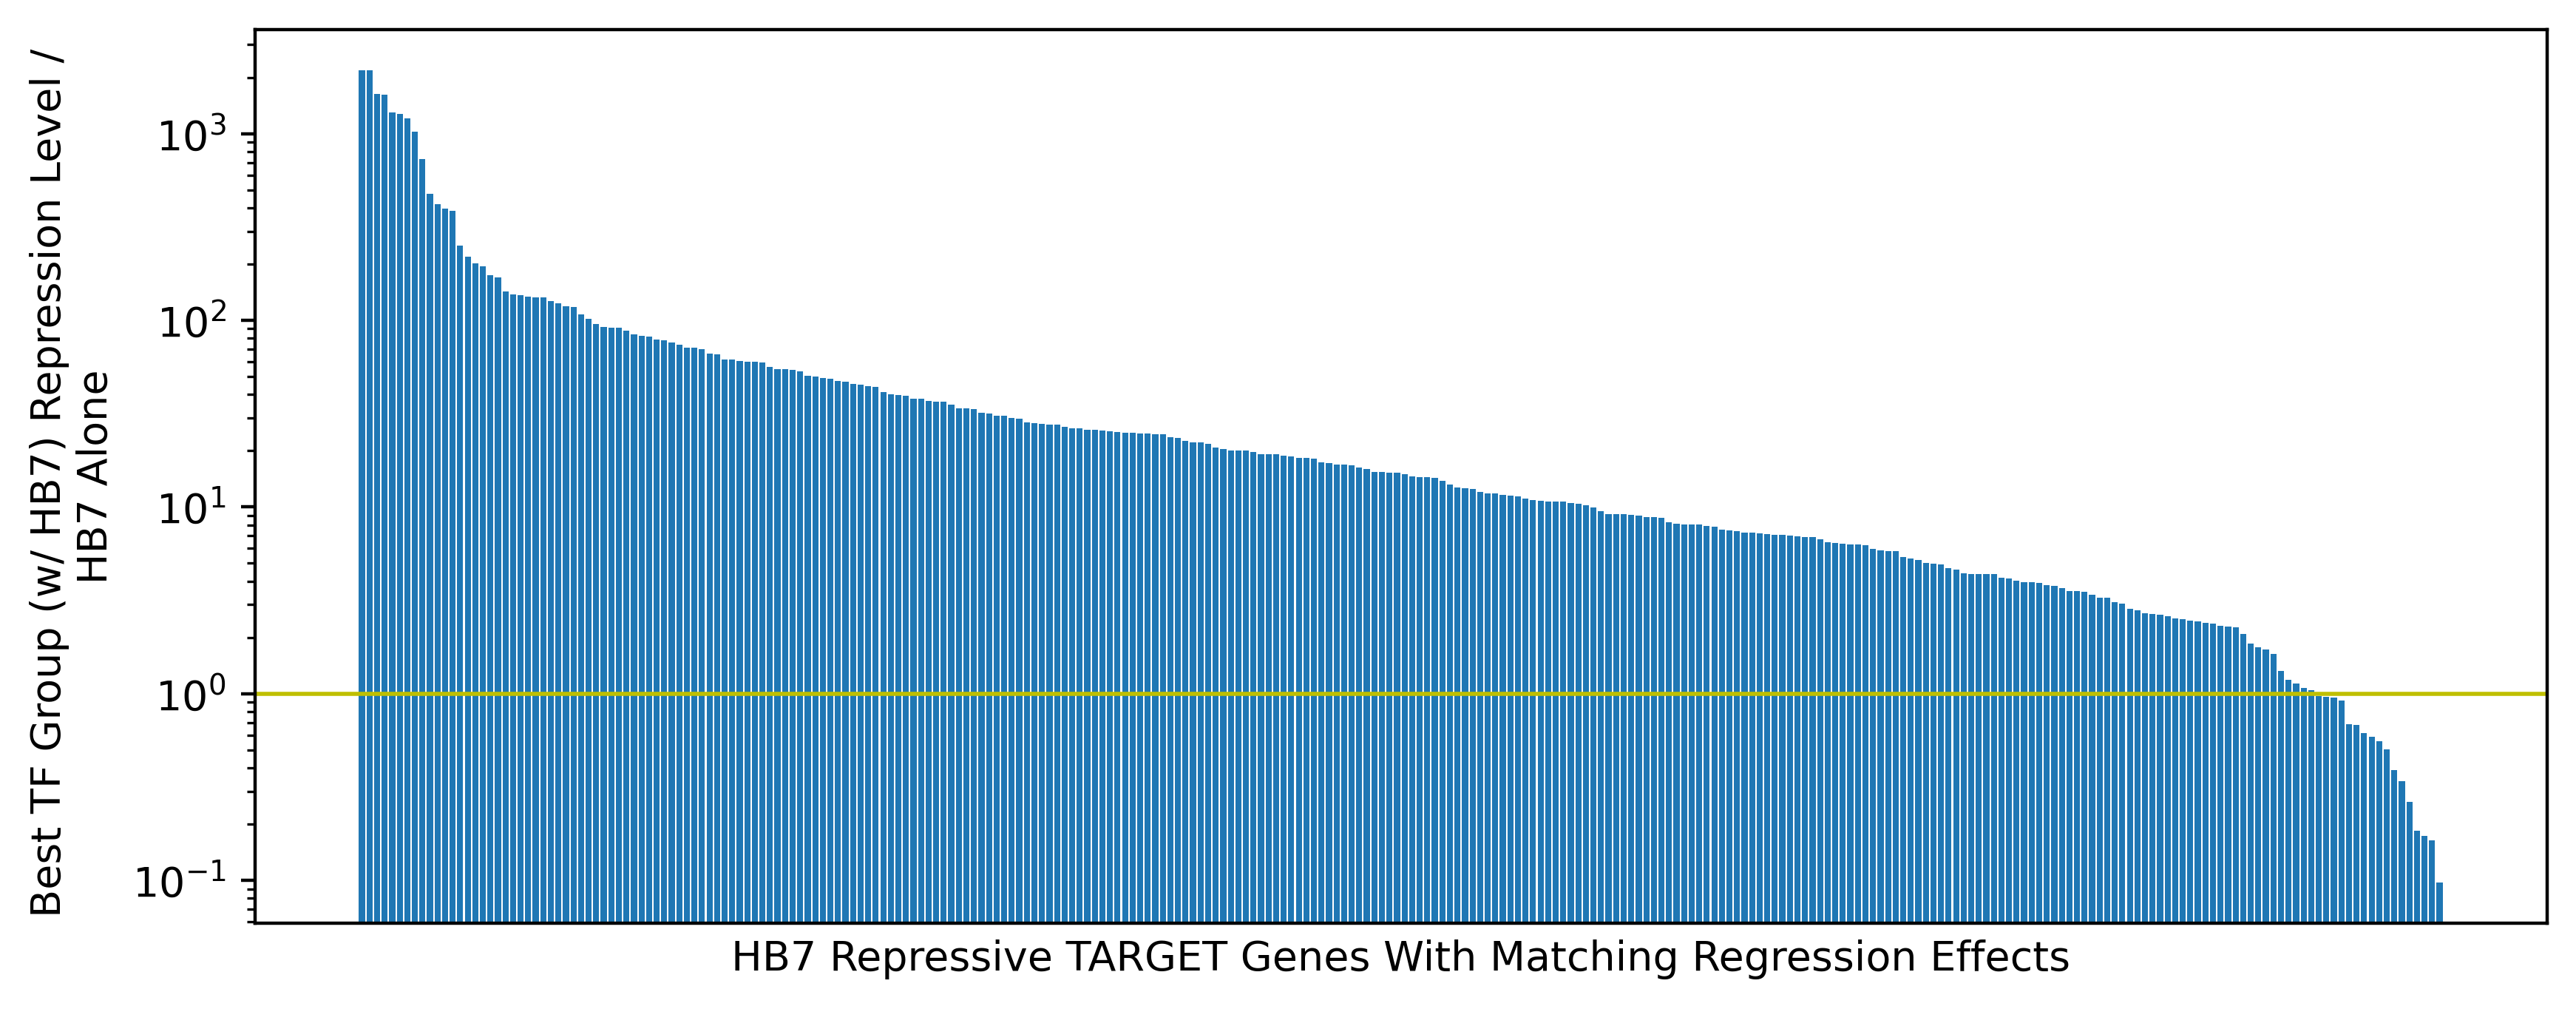

In [17]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,4)
fig.set_dpi(400)
ax1.bar(range(len(good_neg_df)), good_neg_df['fold_change'])
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.axhline(y=1, color='y', linestyle='-', linewidth=0.7)
ax1.set_xlabel('HB7 Repressive TARGET Genes With Matching Regression Effects')
ax1.set_ylabel('Best TF Group (w/ HB7) Repression Level / \n HB7 Alone ')

plt.savefig('./output/wrky_repressive_change.pdf')

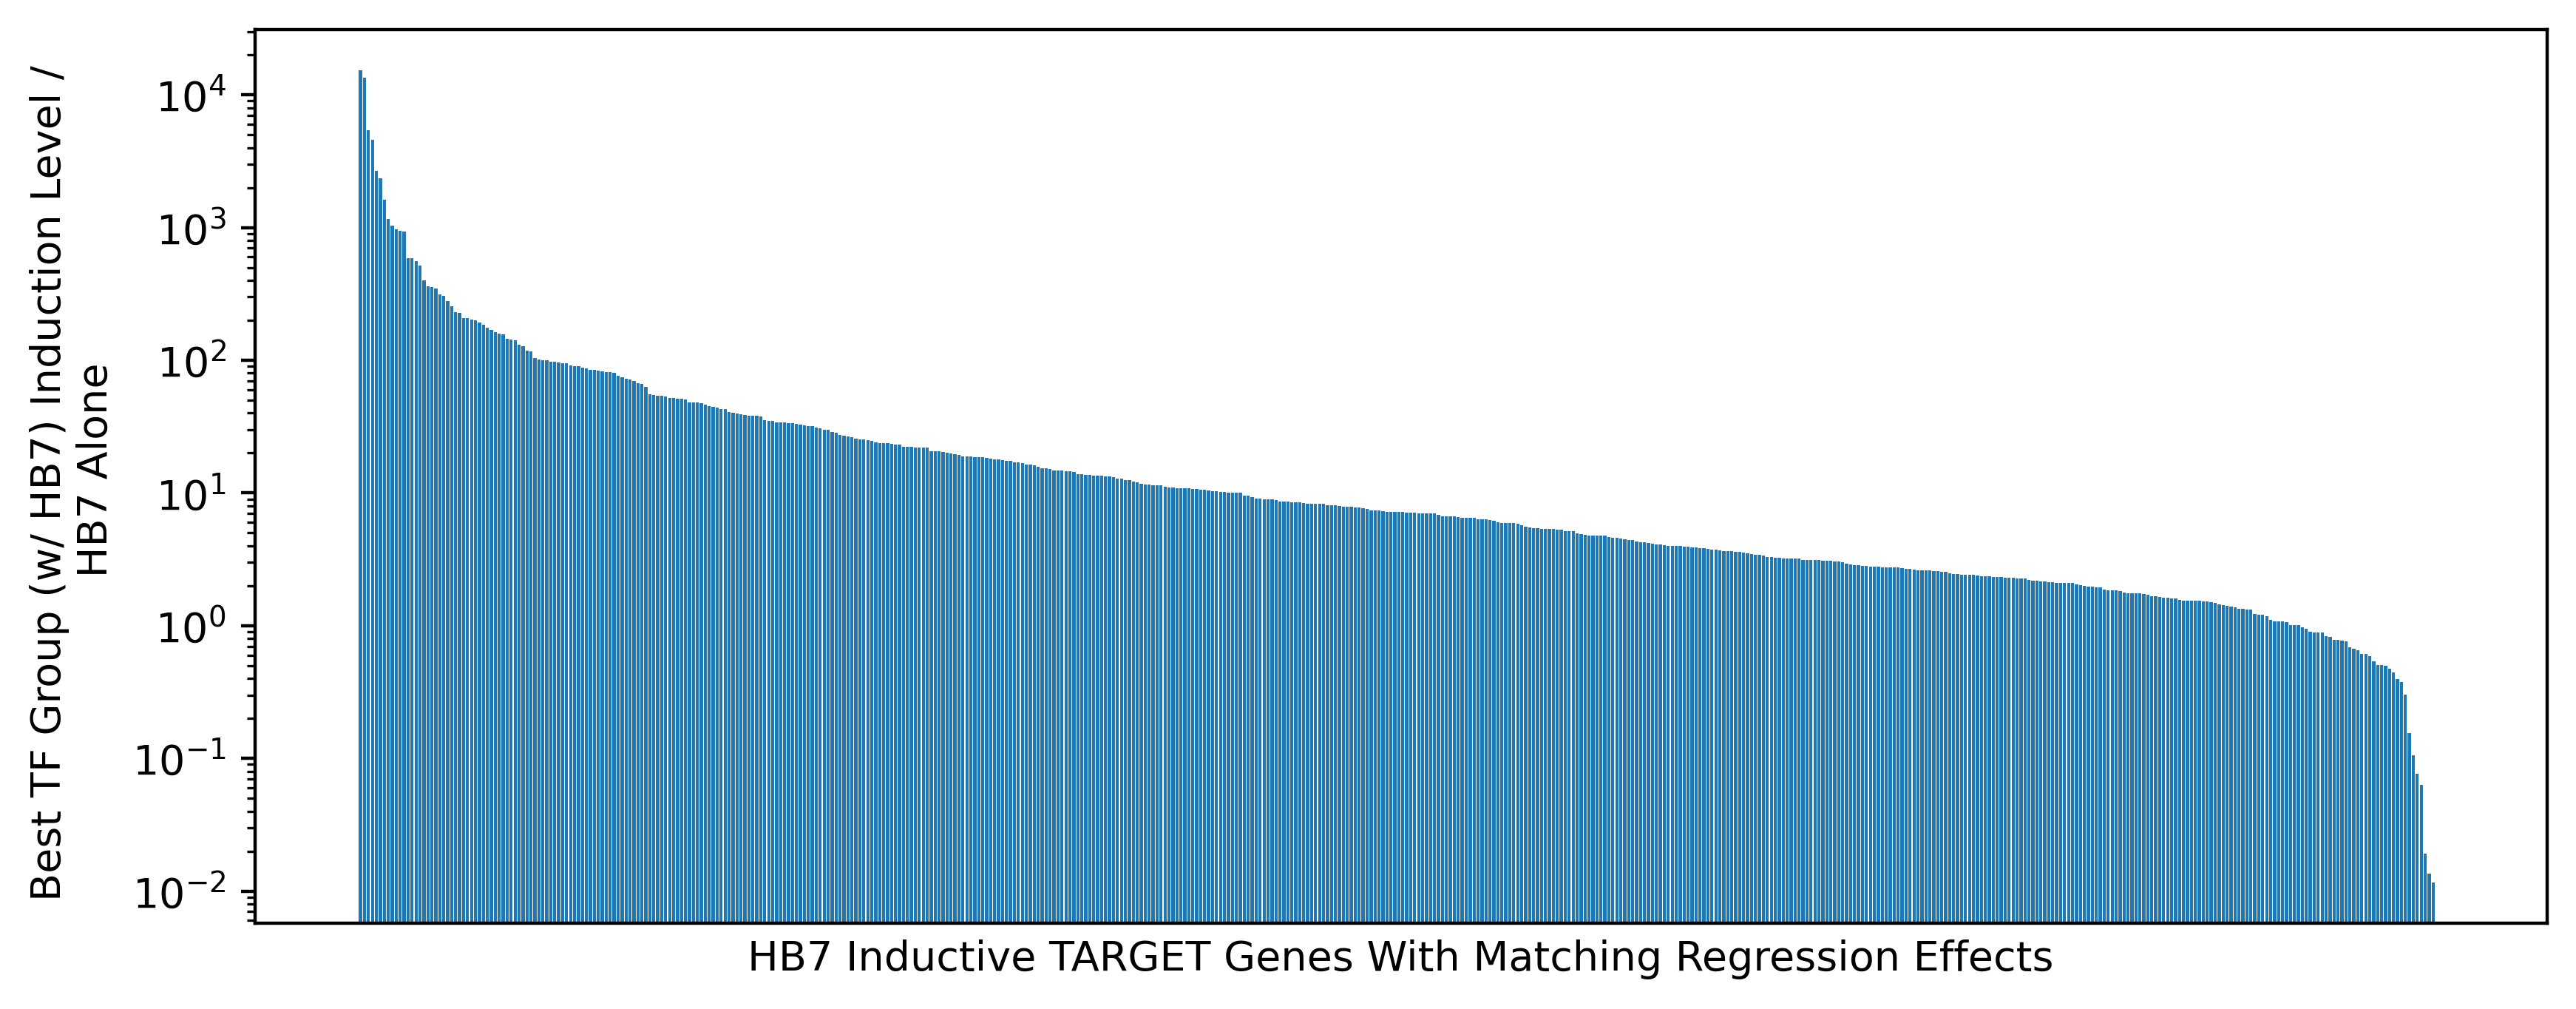

In [60]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,4)
fig.set_dpi(400)
ax1.bar(range(len(good_pos_df)), good_pos_df['fold_change'])
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.set_xlabel('HB7 Inductive TARGET Genes With Matching Regression Effects')
plt.axhline(y=1, color='y', linestyle='-', linewidth=0.7)
ax1.set_ylabel('Best TF Group (w/ HB7) Induction Level / \n HB7 Alone')

plt.savefig('./output/wrky_inductive_change.pdf')

In [29]:
wrky_df = pd.read_csv('./data/wrky_regulators.csv', index_col=0)
wrky_df = wrky_df[:-1]
wrky_df['pos_freq'] = np.zeros(len(wrky_df))
wrky_df['neg_freq'] = np.zeros(len(wrky_df))

In [30]:
for tf_comb in good_neg_df['top_1_combination']:
    tf_list = tf_comb.split('; ')
    for tf in tf_list:
        if tf in wrky_df.index:
            wrky_df.loc[tf, 'neg_freq'] += 1

In [31]:
for tf_comb in good_pos_df['top_1_combination']:
    tf_list = tf_comb.split('; ')
    for tf in tf_list:
        if tf in wrky_df.index:
            wrky_df.loc[tf, 'pos_freq'] += 1

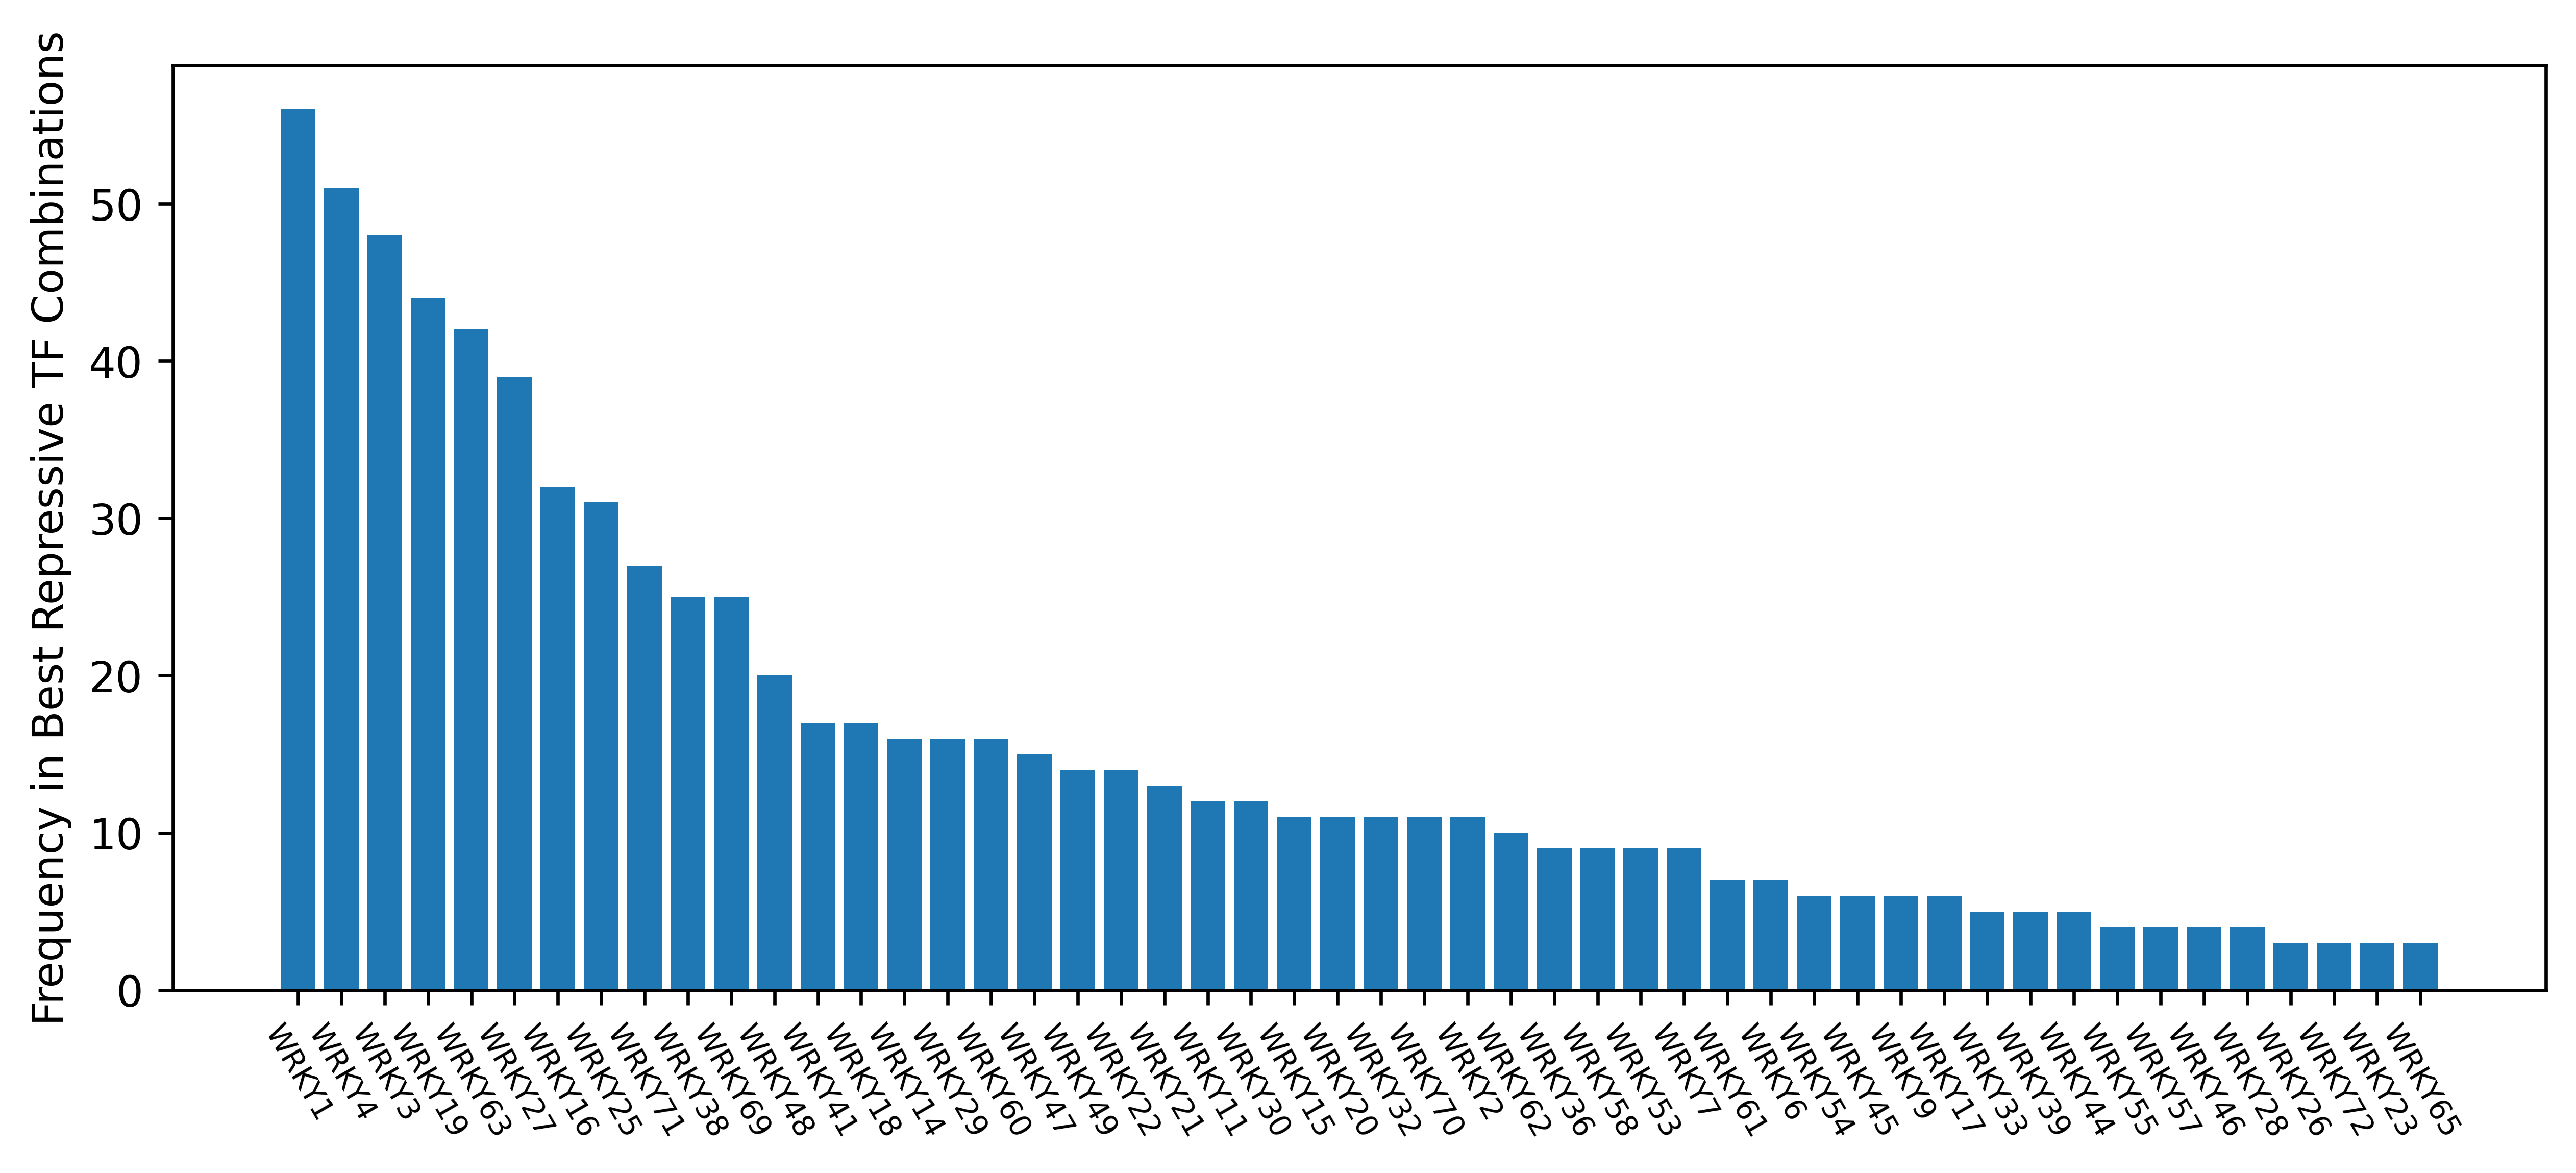

In [48]:
wrky_df = wrky_df.sort_values('neg_freq',ascending=False)
fig, ax1 = plt.subplots()
fig.set_size_inches(10,4)
fig.set_dpi(600)
ax1.bar(wrky_df.Symbol[:50], wrky_df['neg_freq'][:50])
# ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax1.set_xlabel('WRKY TFs')
plt.xticks(fontsize=7, rotation=300)
ax1.set_ylabel('Frequency in Best Repressive TF Combinations')
plt.savefig('./output/wrky_repressive_freq.pdf')  


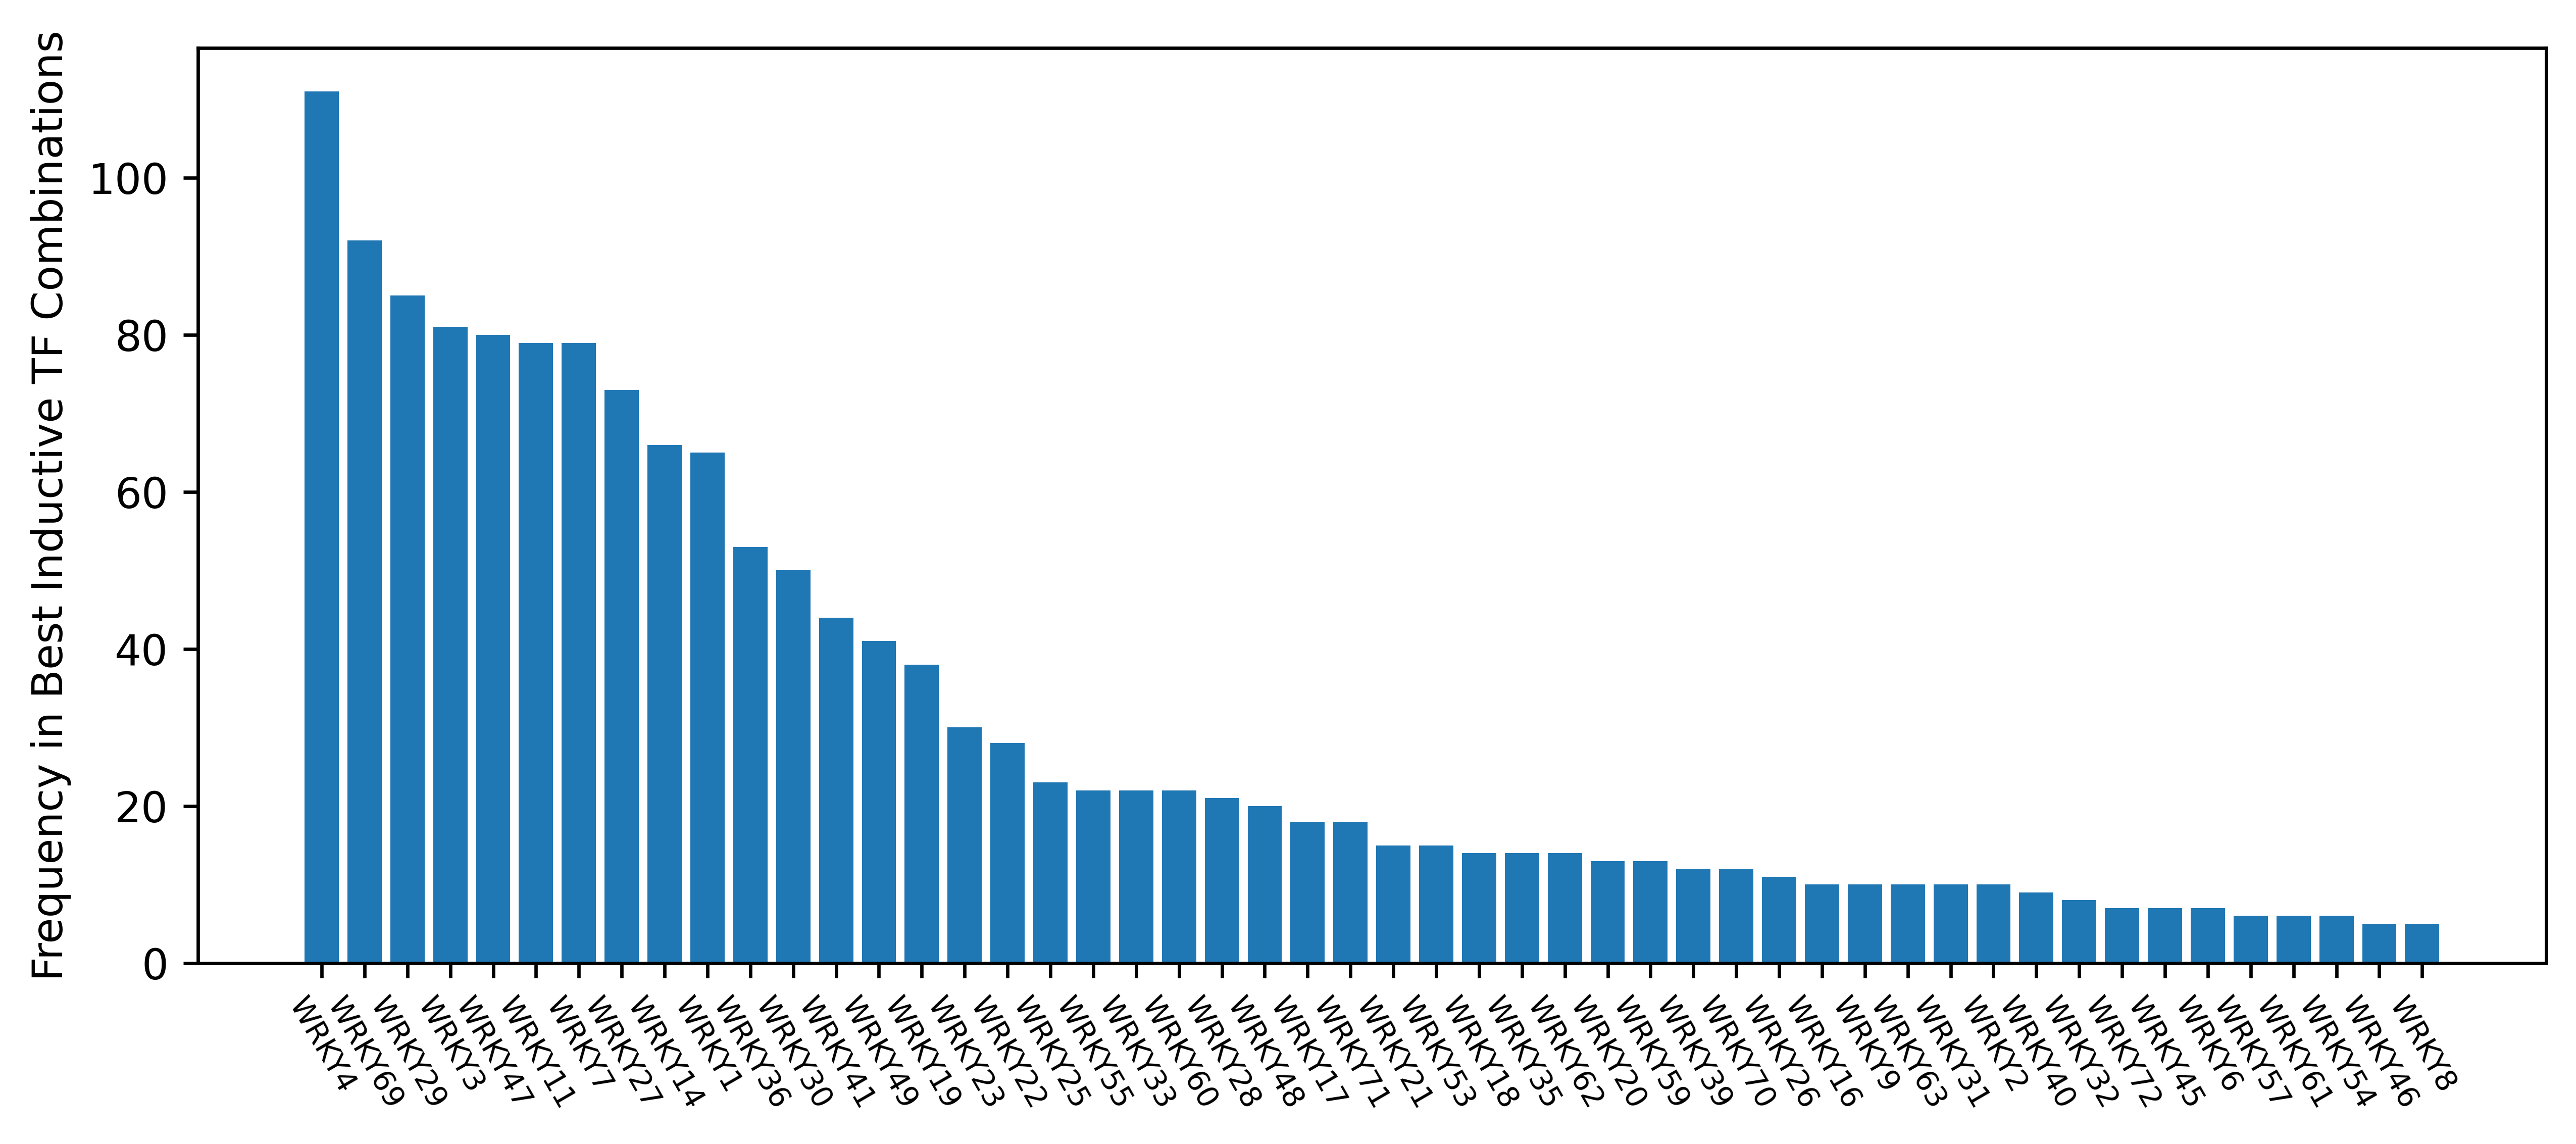

In [50]:
wrky_df = wrky_df.sort_values('pos_freq',ascending=False)
fig, ax1 = plt.subplots()
fig.set_size_inches(10,4)
fig.set_dpi(600)
ax1.bar(wrky_df.Symbol[:50], wrky_df['pos_freq'][:50])
# ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax1.set_xlabel('WRKY TFs')
plt.xticks(fontsize=7, rotation=300)
ax1.set_ylabel('Frequency in Best Inductive TF Combinations')
plt.savefig('./output/wrky_inductive_freq.pdf')

In [27]:
all_comb = good_pos_df[['top_1_combination', 'top_2_combination', 'top_3_combination', 'top_4_combination', 'top_5_combination']].values

filtered_comb = []
for comb in all_comb.ravel():
    tf_list = comb.split('; ')
    tf_list.remove('AT2G46680')
    tf_list.sort()
    filtered_comb.append('; '.join([wrky_df.loc[tf, 'Symbol'] for tf in tf_list]))

res = Counter(filtered_comb)
df = pd.DataFrame(index=res.keys())
df['freq'] = res.values()
df = df.sort_values('freq', ascending=False)

fig, ax1 = plt.subplots()
fig.set_size_inches(8,4)
fig.set_dpi(600)
ax1.bar(df[:50].index, df[:50]['freq'])
# ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax1.set_xlabel('WRKY TFs')
plt.xticks(fontsize=5, rotation=300)
ax1.set_ylabel('Frequency in Top 5 Induction Combinations')



ValueError: list.remove(x): x not in list

Text(0, 0.5, 'Frequency in Top 5 Repression Combinations')

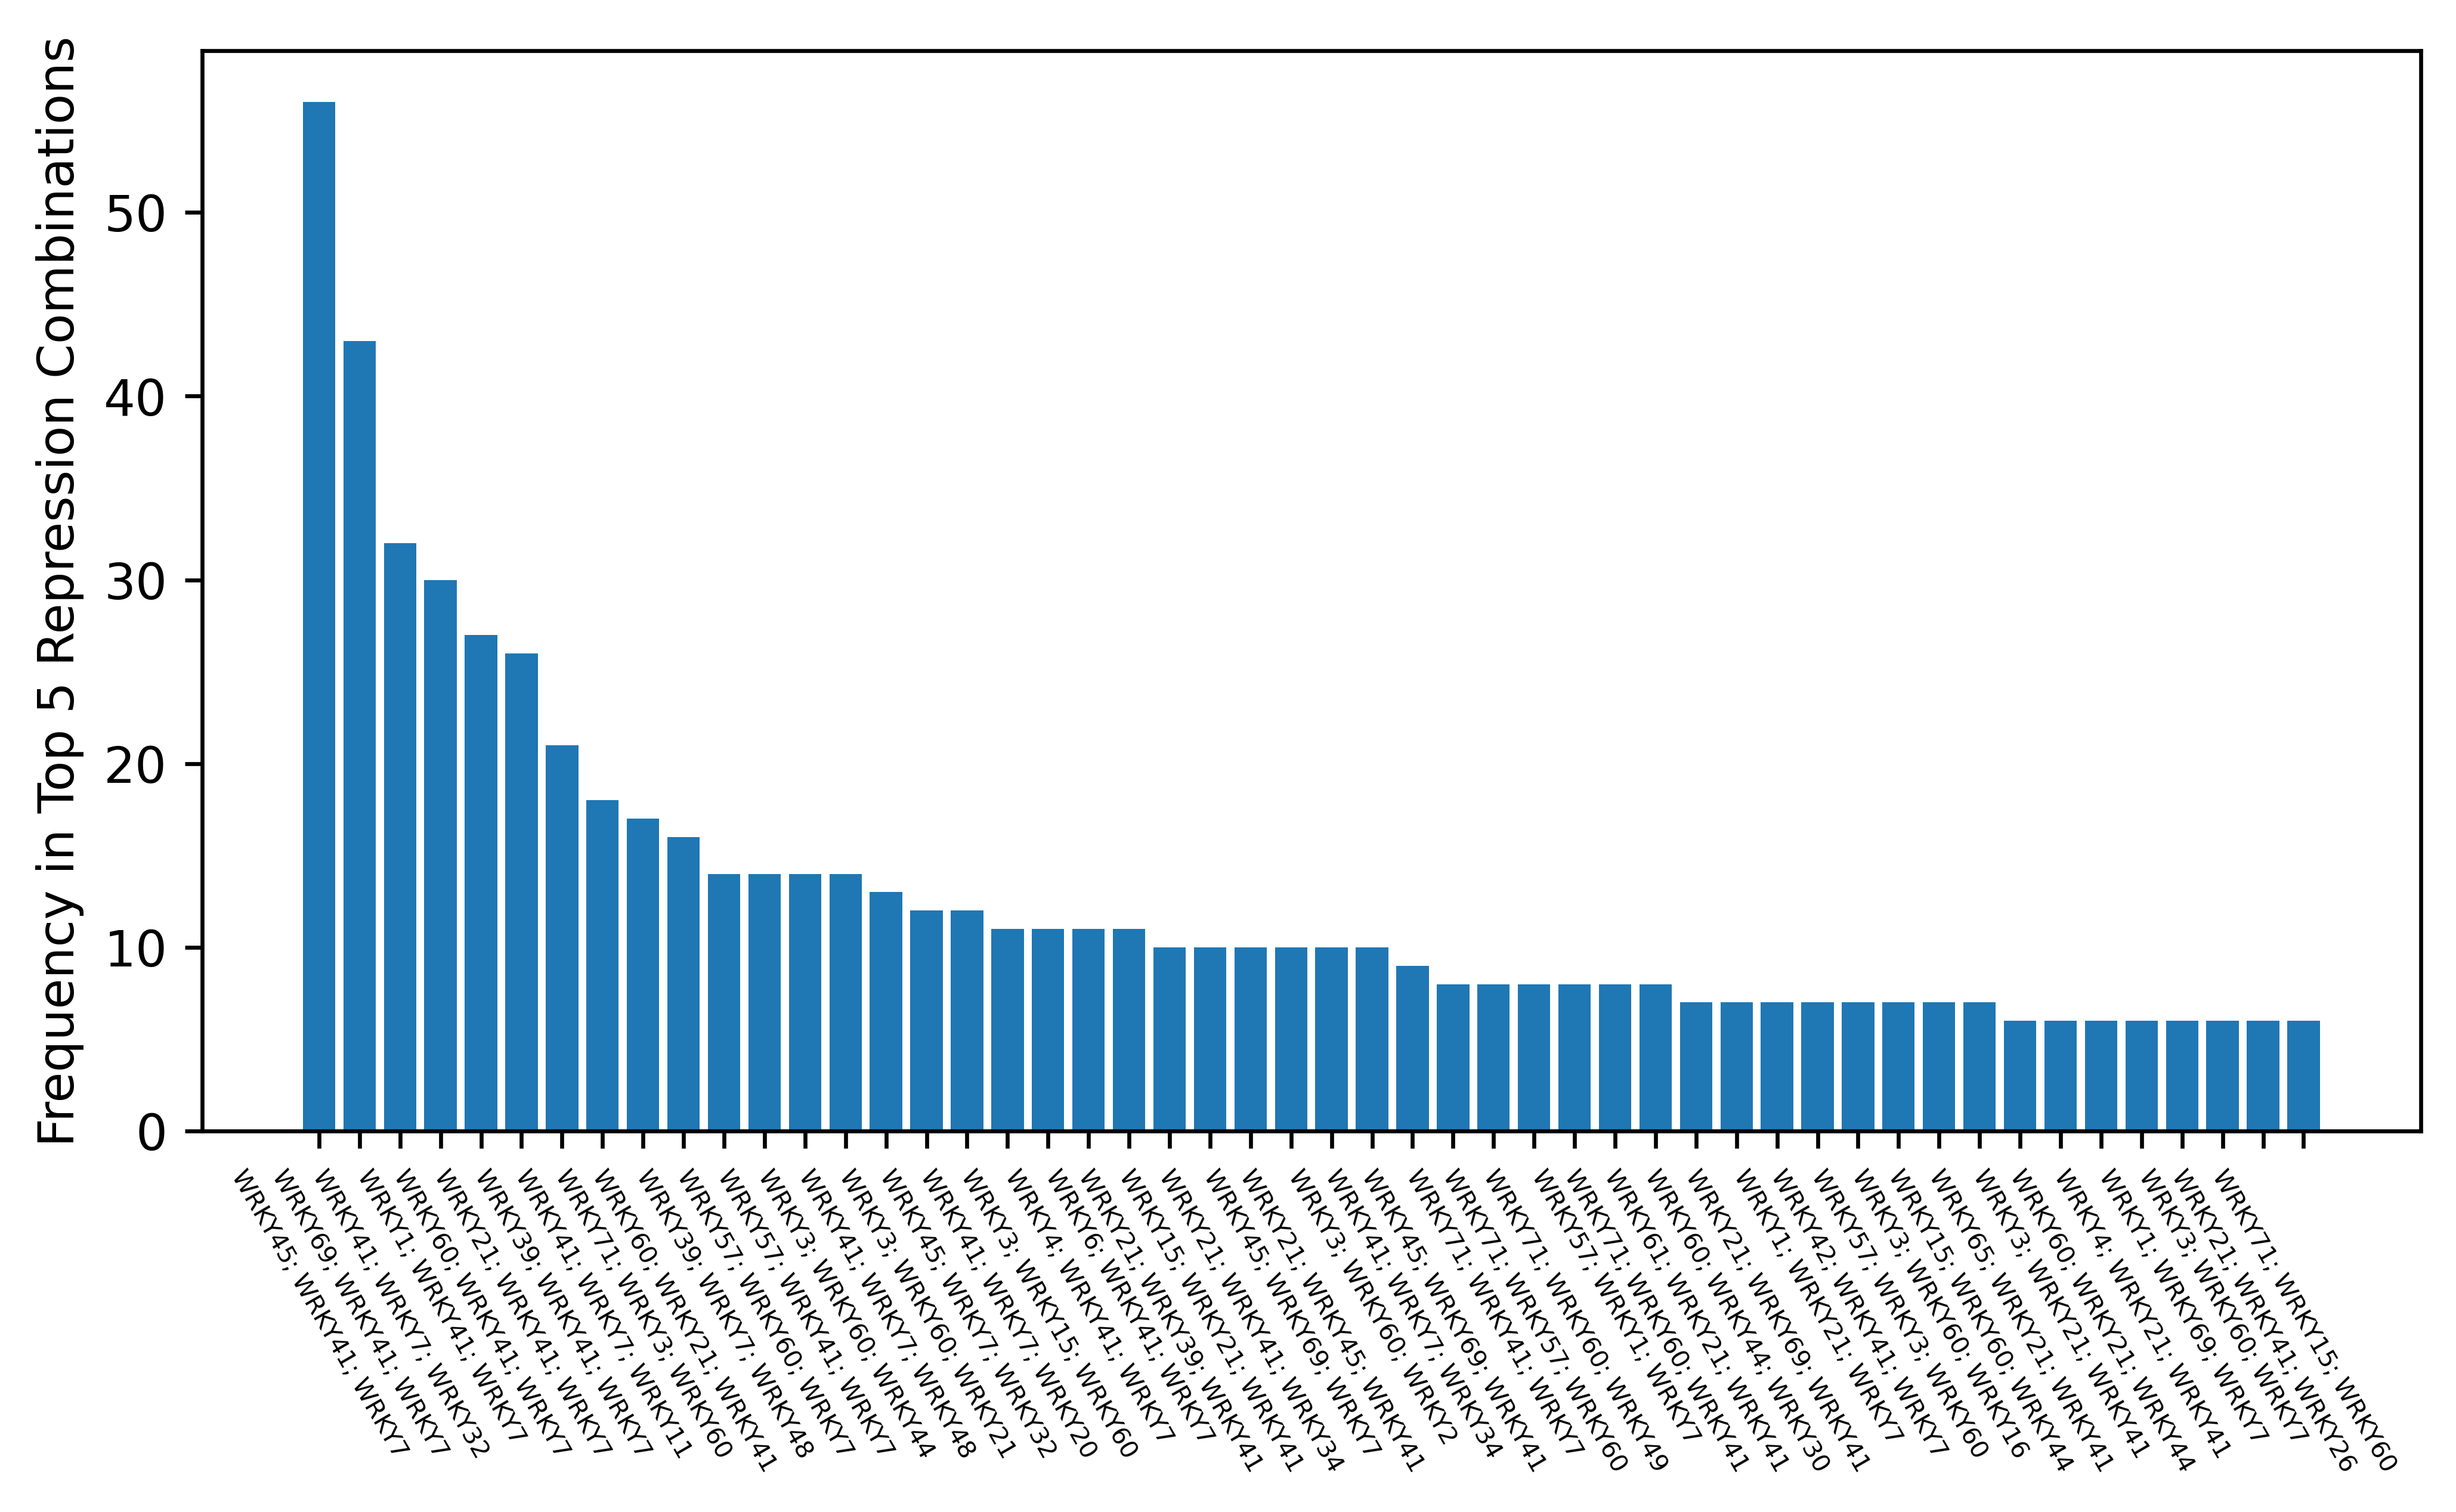

In [236]:
all_comb = good_neg_df[['top_1_combination', 'top_2_combination', 'top_3_combination', 'top_4_combination', 'top_5_combination']].values

filtered_comb = []
for comb in all_comb.ravel():
    tf_list = comb.split('; ')
    tf_list.remove('AT2G46680')
    tf_list.sort()
    filtered_comb.append('; '.join([wrky_df.loc[tf, 'Symbol'] for tf in tf_list]))

res = Counter(filtered_comb)
df = pd.DataFrame(index=res.keys())
df['freq'] = res.values()
df = df.sort_values('freq', ascending=False)

fig, ax1 = plt.subplots()
fig.set_size_inches(8,4)
fig.set_dpi(600)
ax1.bar(df[:50].index, df[:50]['freq'])
# ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax1.set_xlabel('WRKY TFs')
plt.xticks(fontsize=5, rotation=300)
ax1.set_ylabel('Frequency in Top 5 Repression Combinations')

